In [41]:
import os
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import sys
import numpy as np
import numpy.random as nr

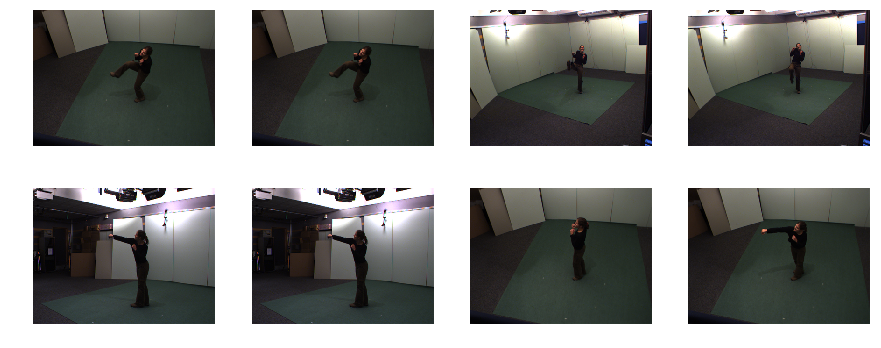

In [42]:
train_data_dir = 'images\\train'
validation_data_dir = 'images\\validation'
nb_train_samples = 38
nb_validation_samples = 20

N = 4
image_filenames = []
fig = plot.figure(figsize=(15,6))
for i, j in enumerate(nr.randint(1, 38, N)):
    fig.add_subplot(2, N, i+1)
    fn = '{}\\chute\\a ({}).png'.format(train_data_dir, j)
    img = plot.imread(fn)
    plot.imshow(img)
    plot.axis('off')
    image_filenames.append(fn)
    
    fig.add_subplot(2, N, i+N+1)
    fn = '{}\\soco\\a ({}).png'.format(train_data_dir, j)
    img = plot.imread(fn)
    plot.imshow(img)
    plot.axis('off')
    image_filenames.append(fn)


In [43]:
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [44]:
# dimensions of our images.
img_width, img_height = 390, 291

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

[2 9 2 9 2 9 2 9]


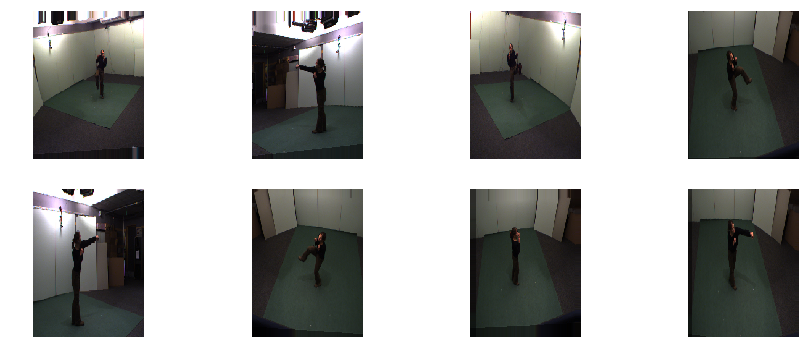

In [45]:
X_s = np.empty((2*N, img_width, img_height, 3), np.uint8)
y_s = np.empty((2*N,), np.int32)

for i, fn in enumerate(image_filenames):
    if fn.split('\\')[-2] == 'aceno':
        y_s[i] = 1
    elif fn.split('\\')[-2] == 'chute':
        y_s[i] = 2
    elif fn.split('\\')[-2] == 'cocando':
        y_s[i] = 3
    elif fn.split('\\')[-2] == 'cruzados':
        y_s[i] = 4
    elif fn.split('\\')[-2] == 'jogando':
        y_s[i] = 5
    elif fn.split('\\')[-2] == 'pegando':
        y_s[i] = 6
    elif fn.split('\\')[-2] == 'relogio':
        y_s[i] = 7
    elif fn.split('\\')[-2] == 'sentado':
        y_s[i] = 8
    elif fn.split('\\')[-2] == 'soco':
        y_s[i] = 9
    else:
        y_s[i] = -1
        
    img = load_img(fn, grayscale=False, target_size=(img_width, img_height))
    X_s[i] = img_to_array(img)
  
print(y_s)

generator = train_datagen.flow(X_s, y_s, batch_size=8)

# Começa a gerar as imagens 'criadas'
X, y = generator.next()

fig = plot.figure(figsize=(15,6))
for i, arr in enumerate(X):
    img = arr.transpose(0, 1, 2)
    fig.add_subplot(2, 4, i+1)
    plot.imshow(img)
    plot.axis('off')

In [46]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 76 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [47]:
print ('Keras ', keras.__version__)

class LeNet:
    @staticmethod
    def build(img_width, img_height):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(64))
        model.add(Activation('relu'))

        model.add(Dropout(0.5))

        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        
        return model

LeNet.build(img_width, img_height).summary()

Keras  2.0.6
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 388, 289, 32)      896       
_________________________________________________________________
activation_41 (Activation)   (None, 388, 289, 32)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 194, 144, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 192, 142, 32)      9248      
_________________________________________________________________
activation_42 (Activation)   (None, 192, 142, 32)      0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 96, 71, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 94, 69, 64)        18496   

In [50]:
from my_keras_utilities import (load_model_and_history, 
                                TrainingPlotter)

model_name = 'models\\4dImages_1'

if not os.path.isfile(model_name + '.model'):
    print("[INFO] creating model...")
    model = LeNet.build(img_width, img_height)
    
    # History, checkpoint, earlystop, plot losses:
    histo = TrainingPlotter(n=1, filepath=model_name, patience=10)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])    
    
else:
    print("[INFO] loading model...")
    model, histo = load_model_and_history(model_name)

[INFO] loading model...


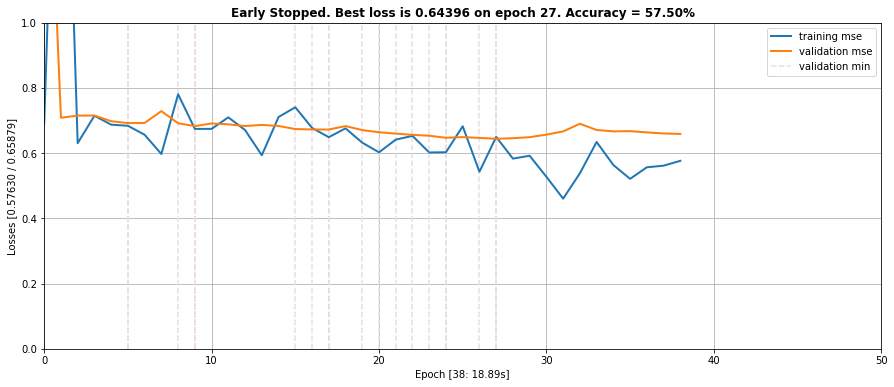

In [51]:
nb_epoch = 50    # trocar para 50
ploss = 1.0

nepochs = nb_epoch - histo.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, ploss)
plot.xlim(0, nb_epoch)
plot.grid(True)

if nepochs > 0:
    print("[INFO] training...")
    try:
        model.fit_generator(
            train_generator,
            samples_per_epoch=nb_train_samples,
            nb_epoch=nepochs,
            validation_data=validation_generator,
            nb_val_samples=nb_validation_samples,
            verbose=0,
            callbacks=[histo],
        )
        
    except KeyboardInterrupt:
        pass
else:
    print("[INFO] plotting...")